<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn


In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samihamuntahamahin","key":"1ad5aaba9143fbd38da418ad8d278398"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [ ]:
# Define the dataset path
DATASET_PATH = "OvarianCancer"  # Folder name of unzipped dataset

# Cancer classes (based on folder names)
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {class_name: i for i, class_name in enumerate(classes)}

# Image size for DenseNet121
IMG_SIZE = 224

# Lists to store images and labels
X, y = [], []

# Load and preprocess images
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)

    if not os.path.exists(class_path):
        continue  # Skip if folder doesn't exist

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        img = cv2.imread(img_path)
        if img is None:
            continue  # Skip unreadable images

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to fit DenseNet121 input
        img = tf.keras.applications.densenet.preprocess_input(img)  # DenseNet121 preprocessing
        X.append(img)
        y.append(class_mapping[class_name])  # Assign label

# Convert lists to NumPy arrays
X = np.array(X)
y = to_categorical(y, num_classes=len(classes))  # One-hot encode labels

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dataset loaded: {len(X)} images")


Dataset loaded: 497 images


In [ ]:
# Load pre-trained DenseNet121 model (exclude the top layers)
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Unfreeze last few layers for fine-tuning
for layer in base_model.layers[-5:]:
    layer.trainable = True

# Add custom layers for our dataset
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)  # Prevent overfitting
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(classes), activation="softmax")(x)

# Create model by connecting base model and custom layers
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Apply augmentation to training data
train_generator = datagen.flow(X_train, y_train, batch_size=16)


In [ ]:
# Train the model
history = model.fit(train_generator, validation_data=(X_test, y_test), epochs=20)

# Evaluate model performance on test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")
print(f"Test Loss: {loss:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 425s 13s/step - accuracy: 0.3528 - loss: 1.9930 - val_accuracy: 0.3900 - val_loss: 3.3175
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 301s 12s/step - accuracy: 0.4971 - loss: 1.4605 - val_accuracy: 0.1700 - val_loss: 31.2940
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 303s 12s/step - accuracy: 0.5698 - loss: 1.4431 - val_accuracy: 0.2300 - val_loss: 38.5894
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 301s 12s/step - accuracy: 0.6158 - loss: 1.1012 - val_accuracy: 0.1800 - val_loss: 40.0446
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 301s 12s/step - accuracy: 0.6978 - loss: 0.9374 - val_accuracy: 0.1600 - val_loss: 229.0137
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 297s 12s/step - accuracy: 0.6644 - loss: 0.9420 - val_accuracy: 0.2200 - val_loss: 148.0345
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 305s 12s/step - accuracy: 0.7331 - loss: 0.8443 - val_accuracy: 0.1600 - val_loss: 42.5551
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 298s 12s/step - accuracy: 0.6691 - loss: 0.9507 - val_accu

In [ ]:
# Save the model
model.save("densenet121_ovarian_cancer_model.h5")
print("Model saved successfully!")


Model saved successfully!


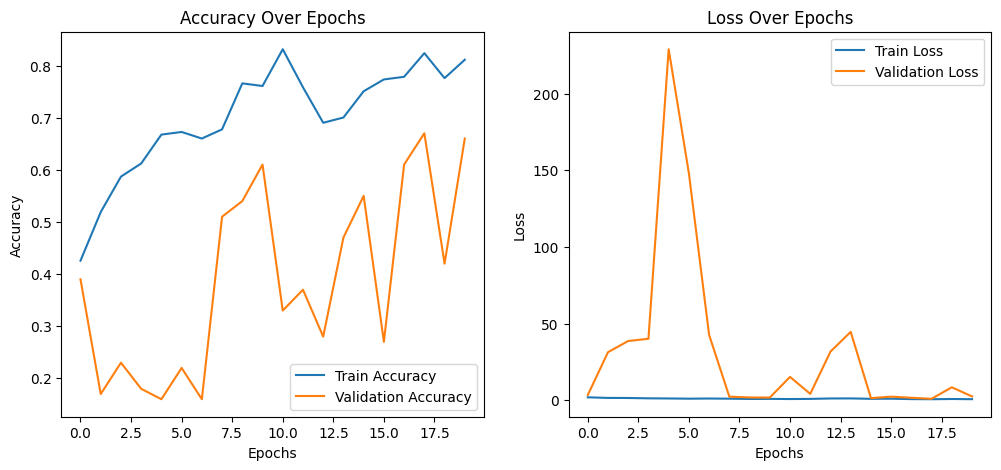

In [ ]:
import matplotlib.pyplot as plt
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()
